## Step 1: 환경 설정

In [1]:
import sys
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math
import pickle

# 현재 디렉토리를 경로에 추가
current_dir = Path('.').resolve()
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))

# 모듈 임포트
from preparation import get_device, load_models
from sequence_generation import fetch_gene_sequences, sort_genes_by_length
from visualization import (
    cosine_series_from_embeddings,
    calculate_shannon_entropy
)

print("✅ 환경 설정 완료")

# matplotlib 설정
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11


✅ 환경 설정 완료


## Step 2: 디바이스 및 모델 로드

In [2]:
# 디바이스 설정
device = get_device()
print(f"\n사용 중인 디바이스: {device}")

# 모델 로드 (generator/evaluator에 사용할 두 모델만)
model_configs = {
    'DNABERT-2': 'zhihan1996/DNABERT-2-117M',
    'NT-v2-500m': 'InstaDeepAI/nucleotide-transformer-v2-500m-multi-species',
}
models = load_models(device, model_configs)
print(f"로드된 모델: {list(models.keys())}")


PyTorch Version: 2.9.1
Using device: mps

사용 중인 디바이스: mps
📥 Downloading DNABERT-2...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ DNABERT-2 Triton patch applied successfully.
[DNABERT-2] Loading model...


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[DNABERT-2] Model loaded successfully.
✅ DNABERT-2 loaded successfully.
[NT-v2-500m] Loading model...
[NT-v2-500m] Model loaded successfully.
✅ NT-v2-500m loaded successfully.

🚀 2 model(s) ready!
로드된 모델: ['DNABERT-2', 'NT-v2-500m']


## Step 3: 생성된 시퀀스 로드

# load model/generated_seq/embeddings


In [9]:
# 결과 디렉토리 설정
SEQ_DIR = Path('results/sequences')

# 모든 시퀀스 로드
all_sequences = {}  # {model_name: {gene_id: {strategy: [sequences]}}}

for model_key in models.keys():
    model_name = model_key.replace("/", "-")
    model_dir = SEQ_DIR / model_name
    all_sequences[model_name] = {}
    
    print(f"\n로드 중: {model_key}")
    
    for csv_file in model_dir.glob("*.csv"):
        gene_id = csv_file.stem
        df = pd.read_csv(csv_file, index_col=0)
            
        # DataFrame을 dictionary로 변환
        sequences_dict = {}
        for strategy in df.index:
            sequences_dict[strategy] = df.loc[strategy].tolist()
        
        all_sequences[model_name][gene_id] = sequences_dict
        print(f"  ✓ {gene_id}: {len(sequences_dict)} strategies")

print(f"\n✅ 시퀀스 로드 완료")
print(f"모델: {list(all_sequences.keys())}")
print(f"유전자: {list(all_sequences[list(all_sequences.keys())[0]].keys())}")


로드 중: DNABERT-2
  ✓ HOXC11: 4 strategies
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ VEGFA: 4 strategies
  ✓ HBB: 4 strategies
  ✓ TTN: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ TPI1: 4 strategies
  ✓ TPI1P1: 4 strategies
  ✓ GAPDH: 4 strategies
  ✓ PTENP1: 4 strategies
  ✓ NEAT1: 4 strategies
  ✓ PTEN: 4 strategies
  ✓ HOTAIR: 4 strategies

로드 중: NT-v2-500m
  ✓ HOXC11: 4 strategies
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ VEGFA: 4 strategies
  ✓ HBB: 4 strategies
  ✓ TTN: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ TPI1: 4 strategies
  ✓ TPI1P1: 4 strategies
  ✓ GAPDH: 4 strategies
  ✓ PTENP1: 4 strategies
  ✓ NEAT1: 4 strategies
  ✓ PTEN: 4 strategies
  ✓ HOTAIR: 4 strategies

✅ 시퀀스 로드 완료
모델: ['DNABERT-2', 'NT-v2-500m']
유전자: ['HOXC11', 'TP53', 'NORAD', 'GAPDHP1', 'VEGFA', 'HBB', 'TTN', 'H4C1', 'STAT3', 'TPI1', 'TPI1P1', 'GAPDH', 'PTENP1', 'NEAT1', 'PTEN', 'HOTAIR']


## Step 4: 임베딩 생성 및 로드 (Self/Cross)


In [10]:
# 임베딩 생성/로드 (self-eval + cross-eval)
def build_cross_embeddings(source_sequences, target_model_instance):
    """한 모델이 다른 모델의 시퀀스를 임베딩"""
    cross_emb = {}  # {gene_id: {strategy: [embeddings]}}
    for gene_id, strategies in source_sequences.items():
        cross_emb[gene_id] = {}
        for strategy, sequences in strategies.items():
            if not sequences:
                continue
            embeddings = []
            for seq in sequences:
                if pd.isna(seq) or seq == '':
                    continue
                try:
                    emb = target_model_instance.get_embedding(str(seq))
                    embeddings.append(emb)
                except Exception:
                    pass
            if embeddings:
                cross_emb[gene_id][strategy] = embeddings
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            elif device == 'mps':
                torch.mps.empty_cache()
    return cross_emb

print('임베딩 생성/로드 중...')

generator_labels = [m for m in ['DNABERT-2', 'NT-v2-500m'] if m in models]
evaluator_labels = [m for m in ['DNABERT-2', 'NT-v2-500m'] if m in models]

RESULTS_DIR = Path('results')

EMBEDDINGS_CACHE_DIR = RESULTS_DIR / 'embeddings'
EMBEDDINGS_CACHE_DIR.mkdir(parents=True, exist_ok=True)

cross_embeddings = {}  # {(generator, evaluator): {gene_id: {strategy: [embeddings]}}}

for gen_label in generator_labels:
    for eval_label in evaluator_labels:
        cache_name = f'embeddings_{gen_label}__by__{eval_label}.pkl'
        cache_path = EMBEDDINGS_CACHE_DIR / cache_name

        loaded = False
        if cache_path.exists():
            try:
                with open(cache_path, 'rb') as f:
                    cross_embeddings[(gen_label, eval_label)] = pickle.load(f)
                print(f"  ✓ 캐시 로드: {cache_path}")
                loaded = True
            except Exception as e:
                print(f"  ⚠️ 캐시 로드 실패: {cache_path} ({e})")

        if loaded:
            continue

        print(f"\n임베딩 생성: {gen_label} sequences → {eval_label} evaluator")
        cross_emb = build_cross_embeddings(
            all_sequences[gen_label],
            models[eval_label]
        )
        cross_embeddings[(gen_label, eval_label)] = cross_emb
        with open(cache_path, 'wb') as f:
            pickle.dump(cross_emb, f, protocol=4)
        print(f"  ✓ 캐시 저장: {cache_path}")

# self-evaluation 임베딩 재사용
all_embeddings = {}  # {model_name: {gene_id: {strategy: [embeddings]}}}
for model_label in models.keys():
    key = (model_label, model_label)
    if key not in cross_embeddings:
        raise FileNotFoundError(f'self-eval 임베딩이 없습니다: {model_label} → {model_label}')
    all_embeddings[model_label] = cross_embeddings[key]

print('✅ 임베딩 준비 완료')


임베딩 생성/로드 중...

임베딩 생성: DNABERT-2 sequences → DNABERT-2 evaluator


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 648
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 648 to 649
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 649 to 650
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 650 to 652
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 652 to 655
  warnings.warn(
/Users/leeminjae/.cache/h

  ✓ 캐시 저장: results/embeddings/embeddings_DNABERT-2__by__DNABERT-2.pkl

임베딩 생성: DNABERT-2 sequences → NT-v2-500m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_DNABERT-2__by__NT-v2-500m.pkl

임베딩 생성: NT-v2-500m sequences → DNABERT-2 evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-500m__by__DNABERT-2.pkl

임베딩 생성: NT-v2-500m sequences → NT-v2-500m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-500m__by__NT-v2-500m.pkl
✅ 임베딩 준비 완료


---
# visualization


## 1. decoding strategy에 따른 model collapse


### overview
각 model별로 strategy에 대한 각 gene의 semantic similarity를 보여줍니다.


''

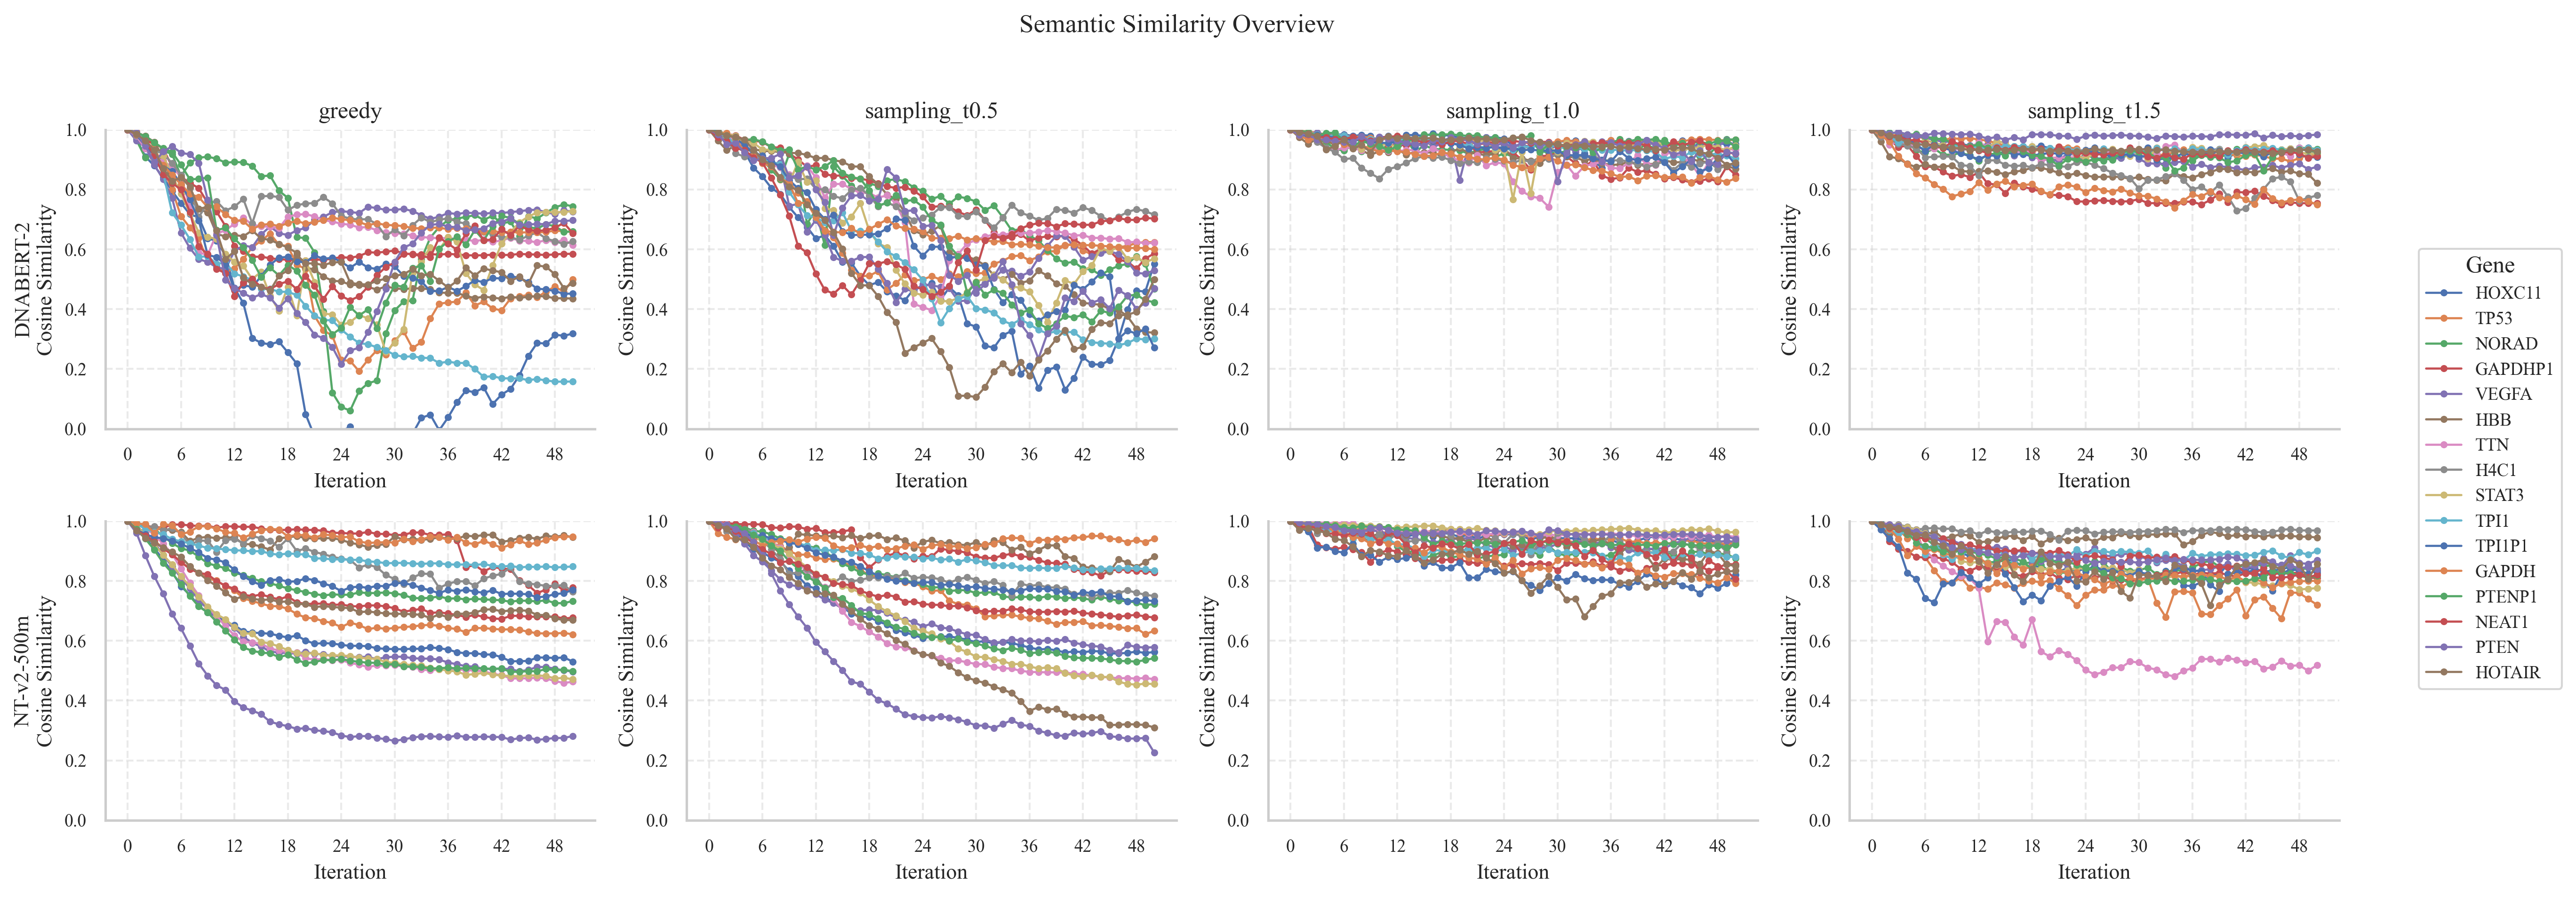

In [11]:
from visualization import (
    plot_similarity_overview_all_models,
    plot_strategy_collapse_with_ci,
    plot_kmer_distribution_pair,
    plot_cross_validation_heatmap,
)

plot_similarity_overview_all_models(
    all_embeddings,
    model_labels=list(all_embeddings.keys()),
)
;

### strategy mean + std
전략별 평균선과 표준편차 음영을 표시합니다.


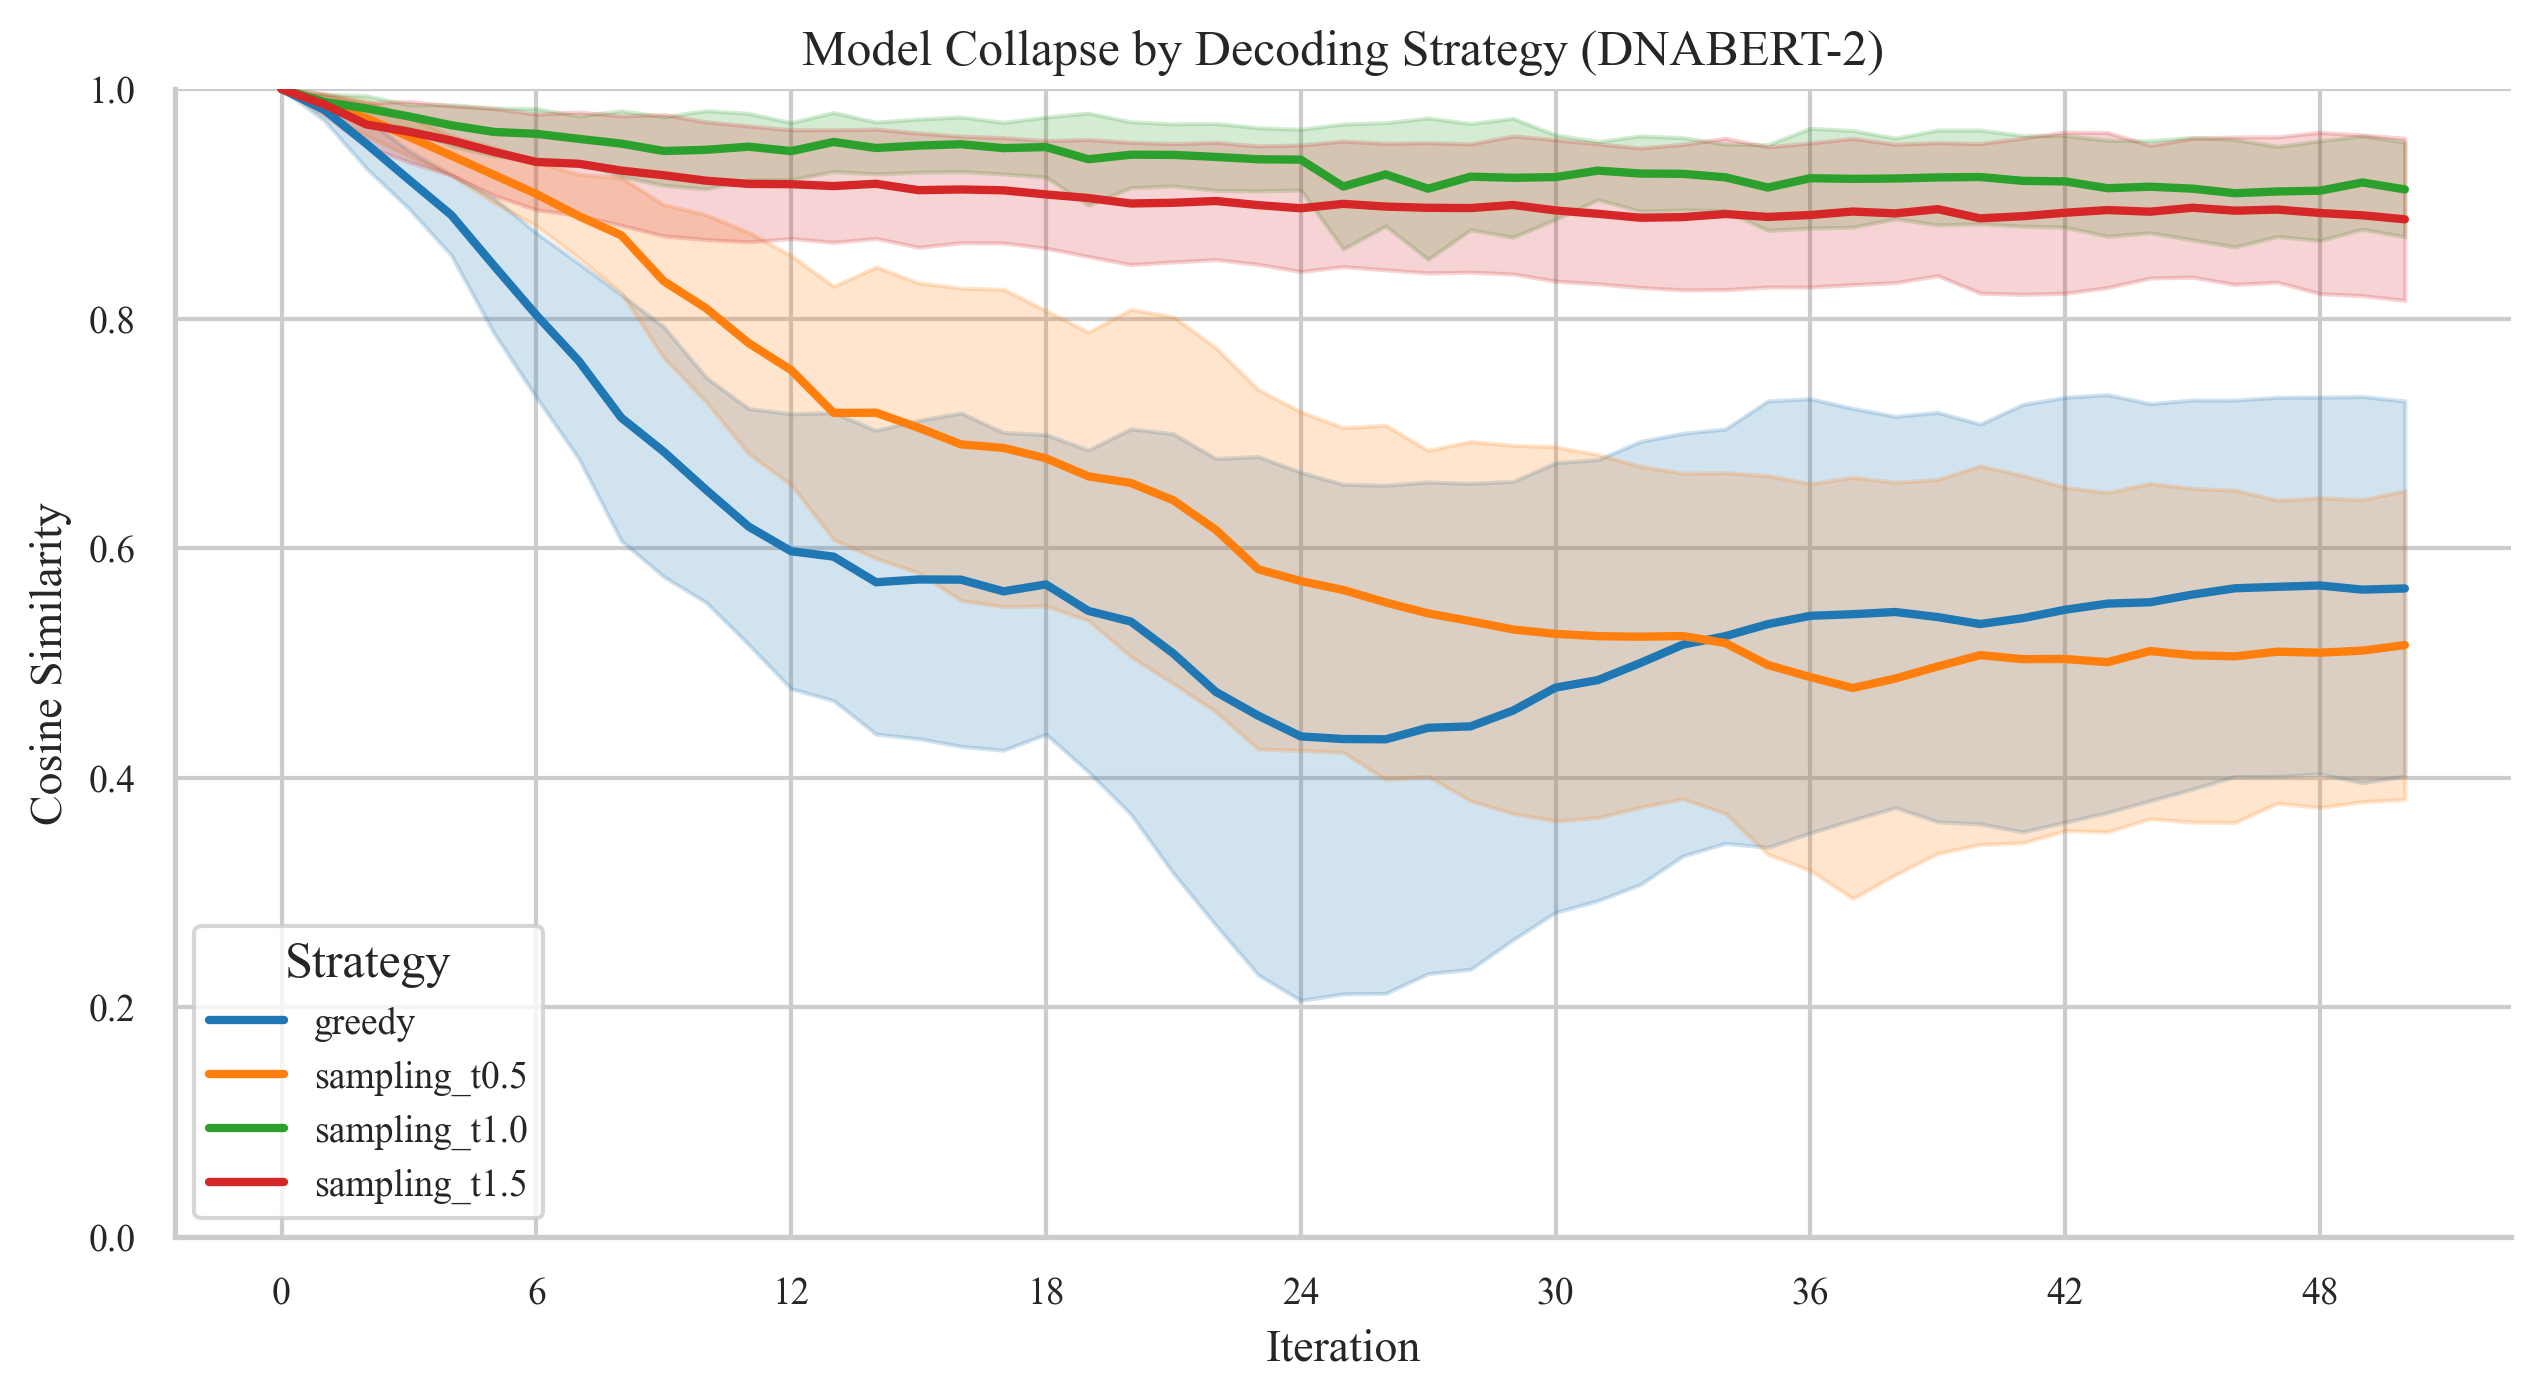

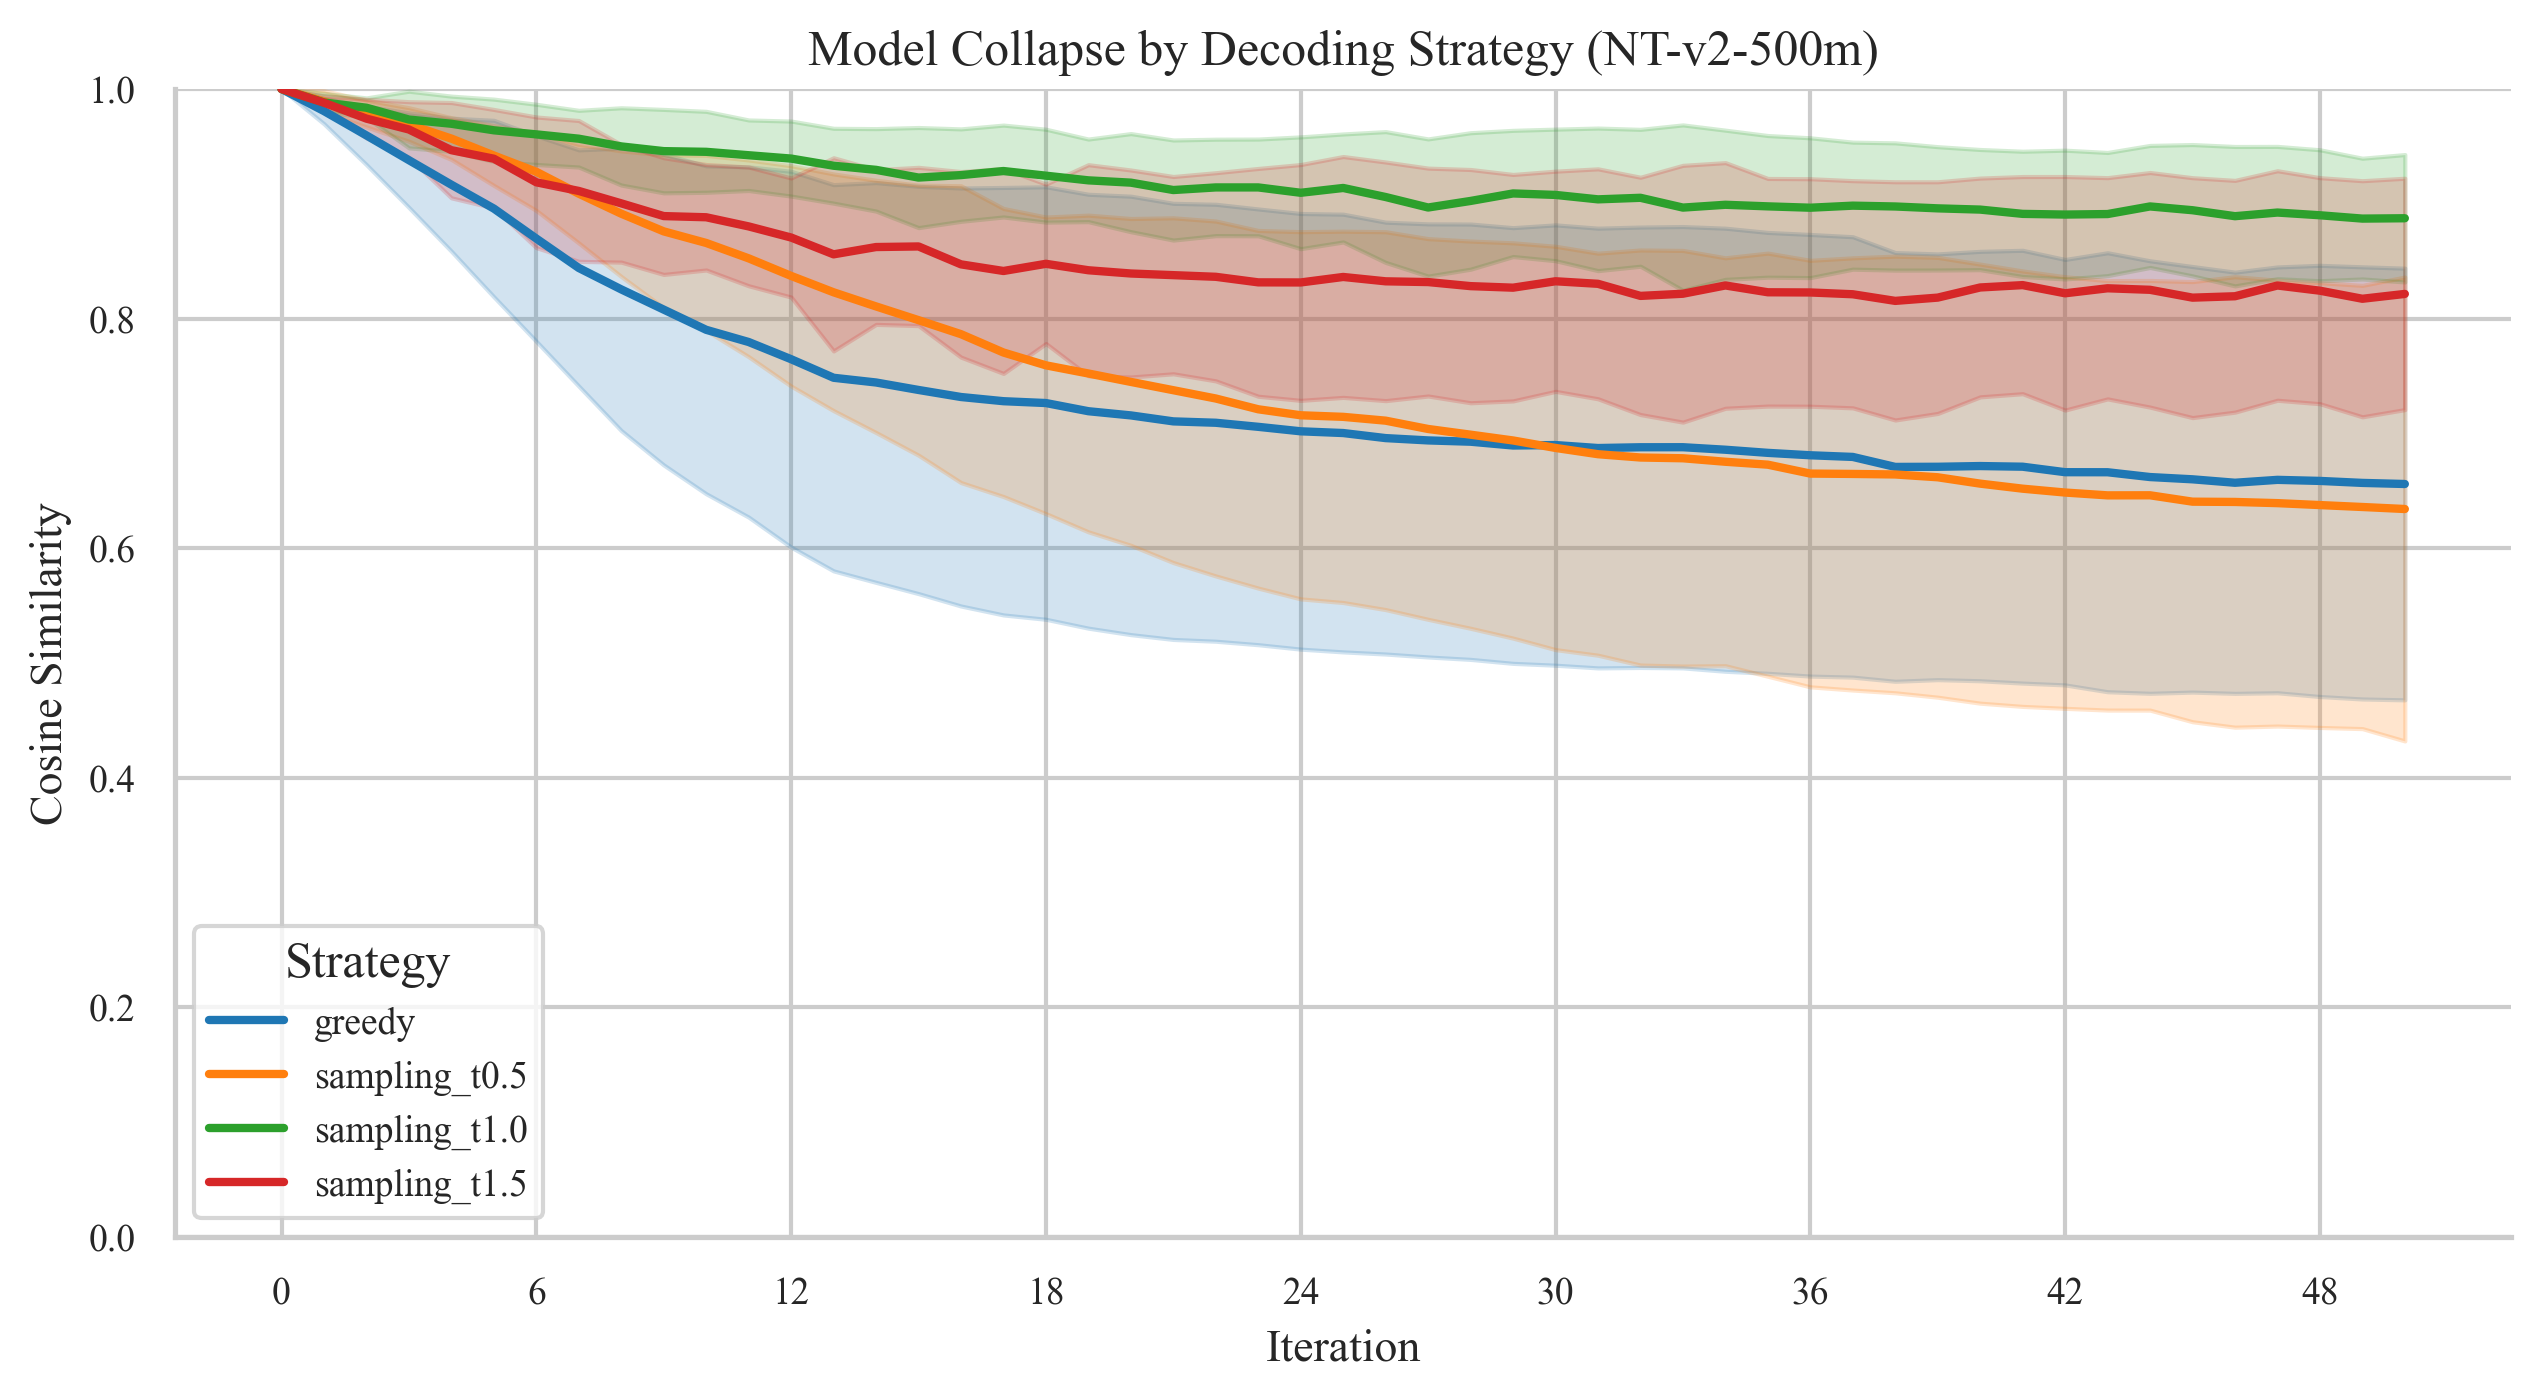

In [12]:
for model_name, embeddings_dict in all_embeddings.items():
    plot_strategy_collapse_with_ci(embeddings_dict, model_label=model_name)


## 2. gene에 따른 model collapse


### gene length, exon 개수에 따른 model collapse


In [ ]:
# 그냥 scatter plot으로 하면 되지 않을까

### real vs. pseudogene
GAPDH vs GAPDHP1의 k-mer 분포 비교 (k=6).


In [13]:
# gene_comparison_model = 'DNABERT-2' if 'DNABERT-2' in all_sequences else next(iter(all_sequences))

# gene_pairs = [
#     ("GAPDH", "GAPDHP1"),
# ]

# for gene_a, gene_b in gene_pairs:
#     plot_kmer_distribution_pair(
#         all_sequences[gene_comparison_model],
#         gene_a=gene_a,
#         gene_b=gene_b,
#         k=6,
#         iteration_index=50,
#     )


## 3. model에 따른 model collapse


### cross validation across models
generator를 model+strategy로 나눠 heatmap을 그립니다.


''

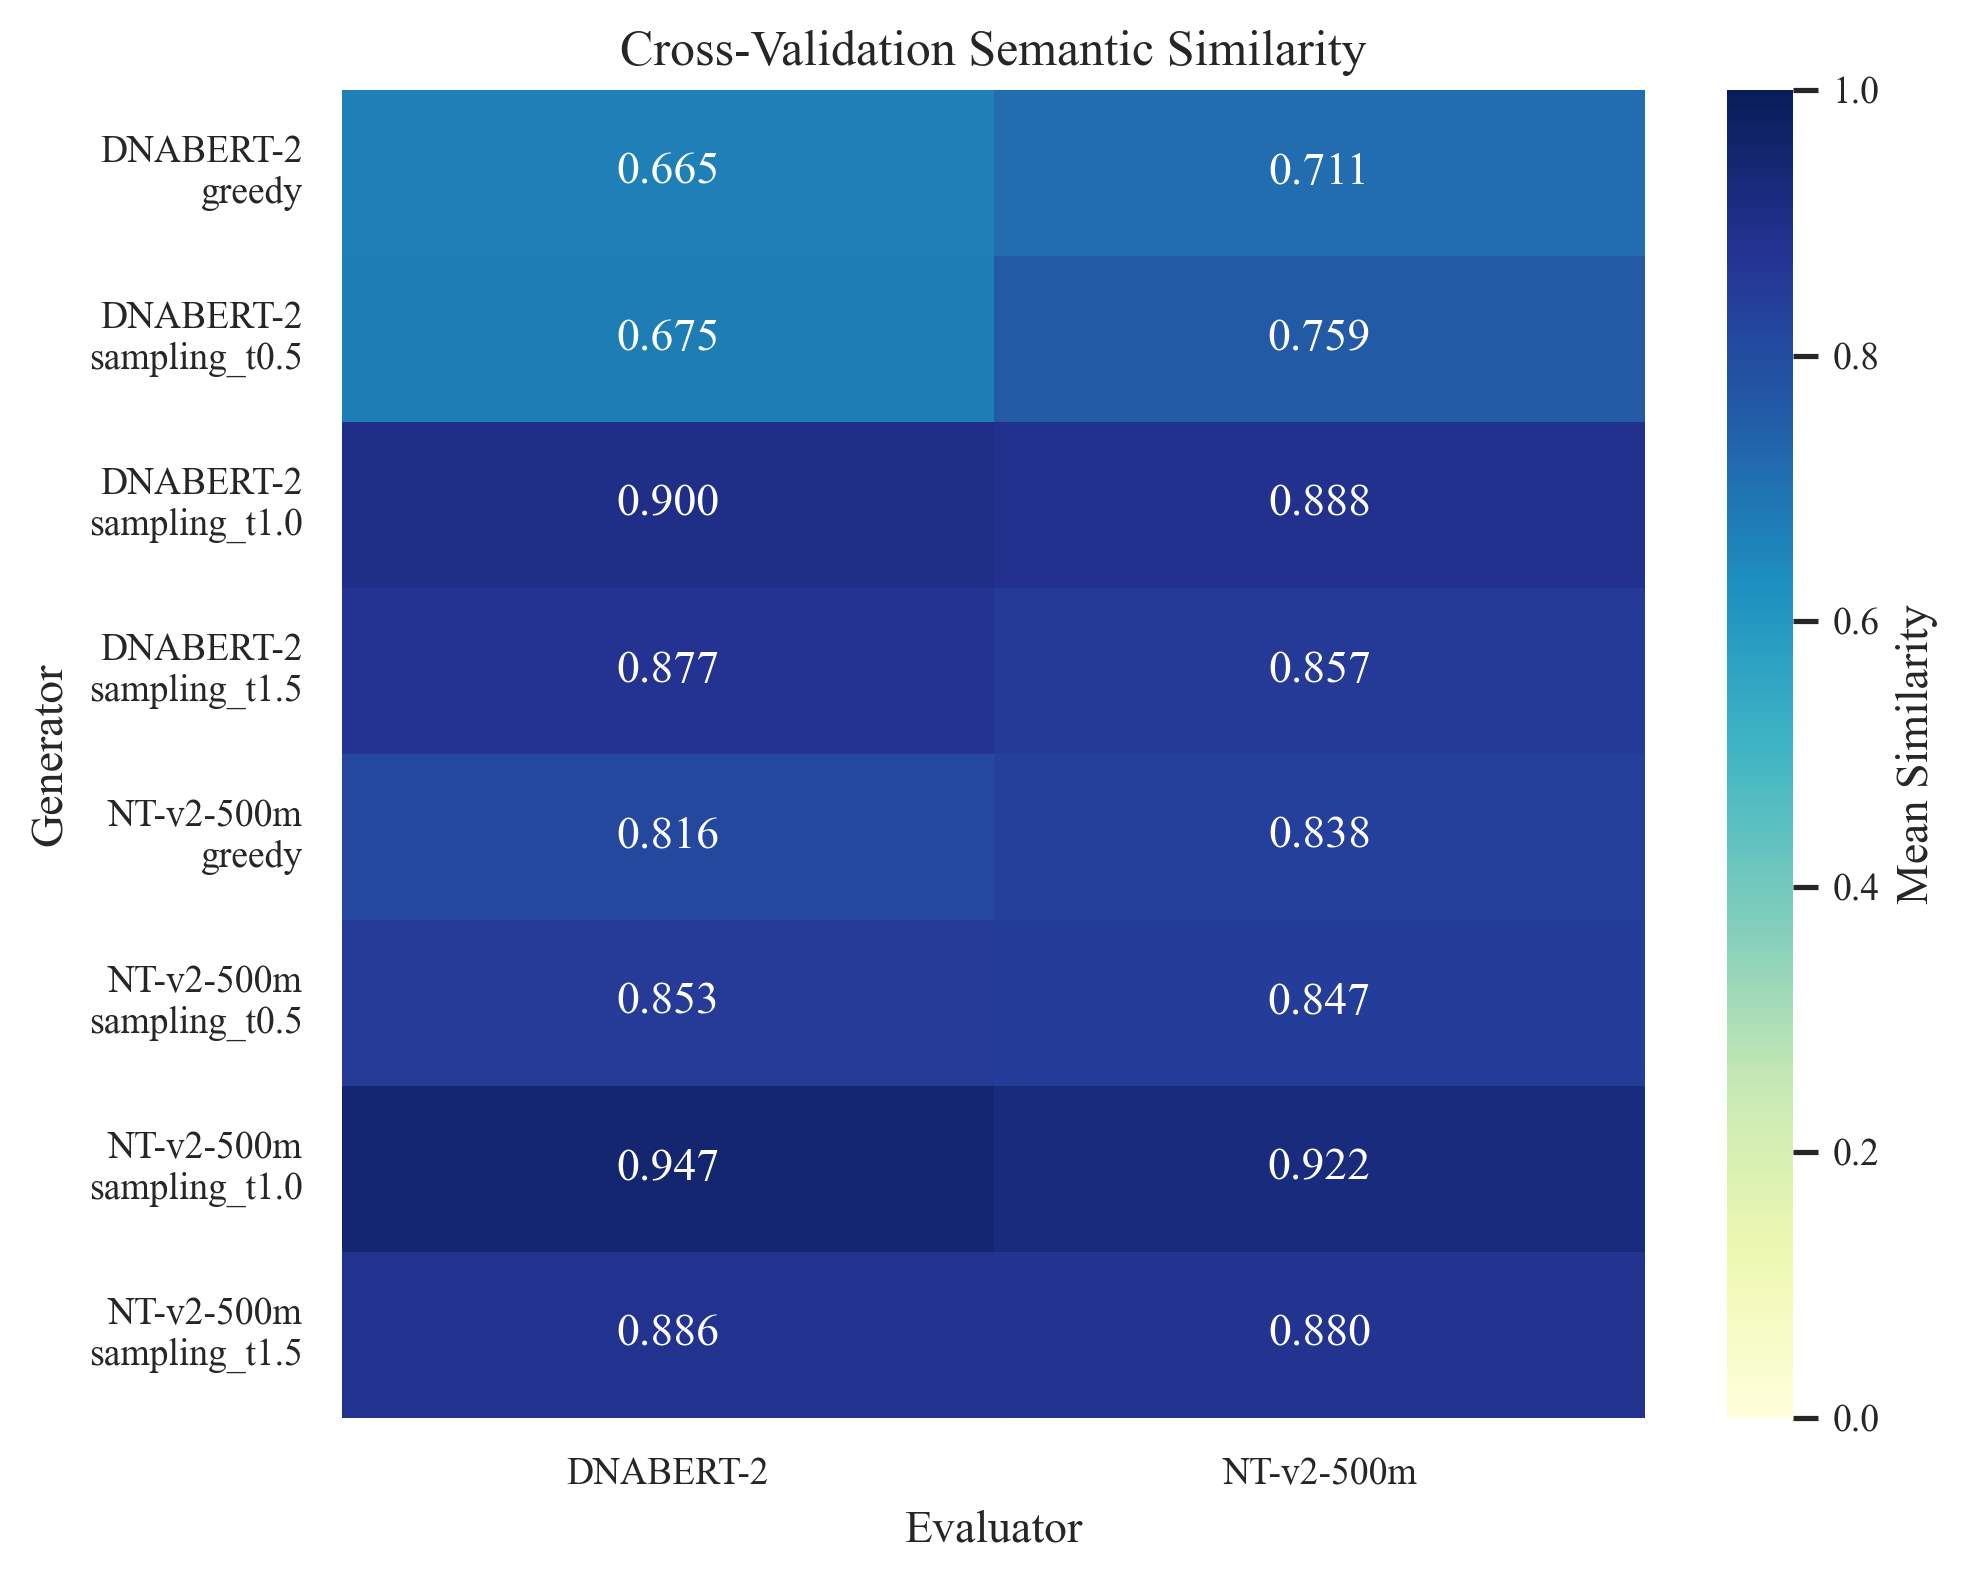

In [8]:
first_model = next(iter(all_embeddings.values()))
first_gene = next(iter(first_model.values()))
strategy_order = list(first_gene.keys())
generator_labels = [
    (model_name, strategy_key)
    for model_name in all_embeddings.keys()
    for strategy_key in strategy_order
]

plot_cross_validation_heatmap(
    cross_embeddings,
    generator_labels=generator_labels,
    evaluator_labels=list(all_embeddings.keys()),
    iteration_range=(0, 50),
)
;